<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from IPython.display import Image

!pip install numba
from numba import cuda

Poniższy blok pobiera dataset z Kaggle. Po uruchomieniu możliwe jest wybranie pliku, który posłuży jako klucz dostępu (Konto Kaggle -> Ustawienia -> API/Create new token).

**Datasets**
* https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
* https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images


In [2]:
from google.colab import files
%cd /content
files.upload()

kaggle_path = "cashbowman/ai-generated-images-vs-real-images"

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $kaggle_path

import zipfile
zip_ref = zipfile.ZipFile(kaggle_path.split('/')[-1] + '.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

/content


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0
 98% 465M/476M [00:05<00:00, 95.1MB/s]
100% 476M/476M [00:06<00:00, 83.1MB/s]


In [3]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
device = cuda.get_current_device()
device.reset()

In [5]:
datasetPath = "/content/kaggle"

imgDim = (256, 256)
batchSize = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    label_mode='binary',
    seed=500,
    image_size=imgDim,
    batch_size=batchSize,
    shuffle=True
)

trainingSetSize = 0.8
validationgSetSize = 0.1

datasetSize = len(dataset)
trainBatches = int(datasetSize * trainingSetSize)
validationBatches = int(datasetSize * validationgSetSize) + 1
testingBatches = datasetSize - trainBatches - validationBatches

trainingSet = dataset.take(trainBatches)
validationSet = dataset.skip(trainBatches).take(validationBatches)
testingSet = dataset.skip(trainBatches + validationBatches)

trainingSet = trainingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testingSet = testingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Testing set lenght:", len(testingSet))
print("Training classes: ", dataset.class_names)



Found 971 files belonging to 2 classes.
Training set lenght: 24
Validation set lenght: 4
Testing set lenght: 3
Training classes:  ['AiArtData', 'RealArt']


In [6]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

---
# VGG16
---

In [8]:
EffNetV2_base = tf.keras.applications.EfficientNetV2B3(
    weights='imagenet',
    input_shape=(*imgDim, 3),
    include_top=False,
    pooling='max'
)
EffNetV2_base.trainable = False

input = tf.keras.Input(shape=(*imgDim, 3))

x = EffNetV2_base(input, training=False)
x = tf.keras.layers.Flatten()(x)
x = BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True
)(x)

# x = Dense(
#     256,
#     activation="relu",
#     kernel_regularizer=regularizers.l2(0.001),
#     bias_regularizer=regularizers.l2(0.001),
#     activity_regularizer=regularizers.l1(0.001)
# )(x)

x = Dropout(
    rate = .6,
    seed = 500
)(x)
output = Dense(1, activation="sigmoid")(x)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .005),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG16_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,303 (49.36 MB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 12,933,694 (49.34 MB)

In [9]:
print("Starting training at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 200,
    verbose = 1,
    callbacks = [early_stopping],
    class_weight={0: 0.906, 1: 1.116}
)
print("Finished trainging at", datetime.now())
%cd /content
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting training at 2025-05-17 19:58:57.004274
Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5618 - loss: 1.0748 - precision_1: 0.5075 - recall_1: 0.5407 - val_accuracy: 0.6328 - val_loss: 0.9986 - val_precision_1: 0.7500 - val_recall_1: 0.2632
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.6837 - loss: 0.6958 - precision_1: 0.6396 - recall_1: 0.6640 - val_accuracy: 0.7500 - val_loss: 0.6307 - val_precision_1: 0.8205 - val_recall_1: 0.5614
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7436 - loss: 0.6335 - precision_1: 0.6995 - recall_1: 0.7441 - val_accuracy: 0.7969 - val_loss: 0.5385 - val_precision_1: 0.8605 - val_recall_1: 0.6491
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7258 - loss: 0.6186 - precision_1: 0.6797 - recall_1: 0.7290 - val_accuracy: 0.8359 - val_loss: 0.4816 - val_precision_1: 0.8750 - val_recall_1: 0.7368
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7392 - loss: 0

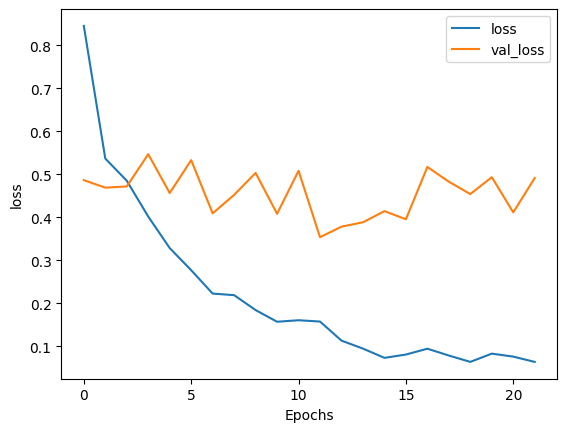

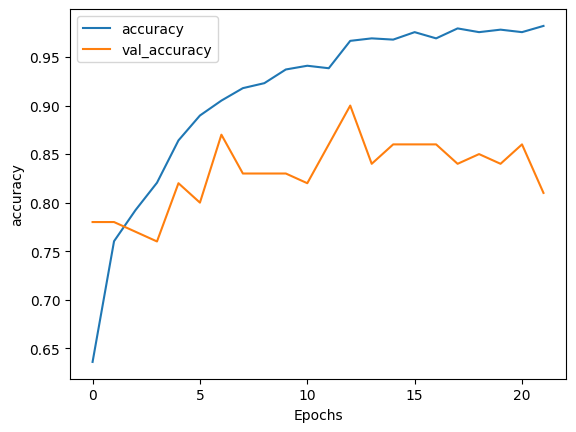

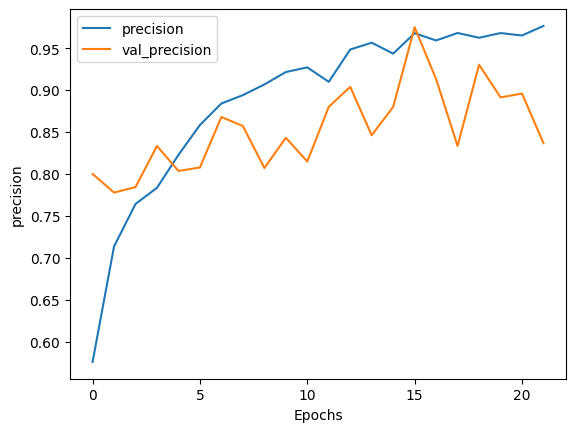

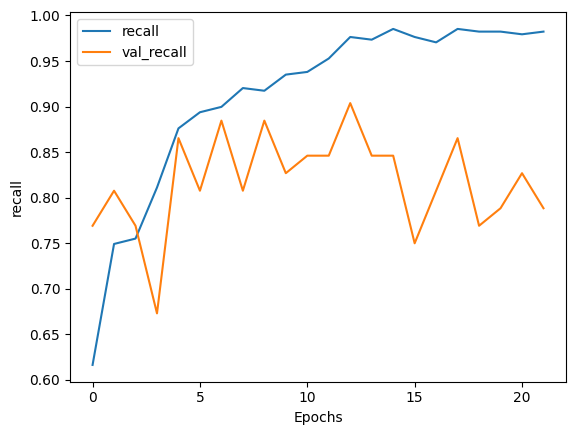

In [ ]:
plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision")
plotMetrics(VGG16_history, "recall")

---
# Testing
---

In [10]:
%cd /content
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

/content


In [11]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9170 - loss: 0.2346 - precision_1: 0.8906 - recall_1: 0.9154
Loss: 0.2425
Accuracy: 0.9200
Precision: 0.9062
Recall: 0.9062


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


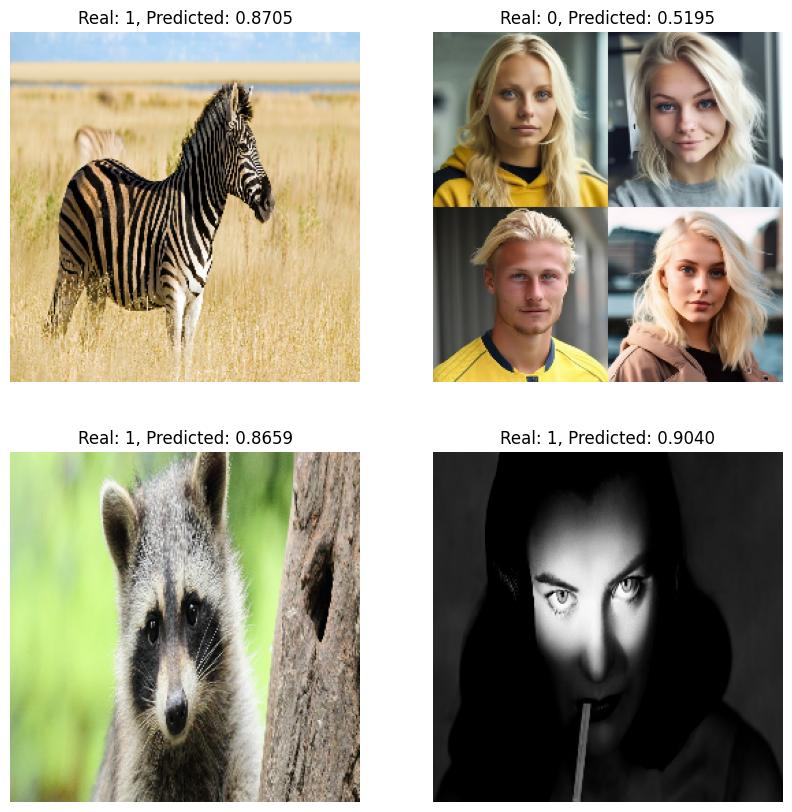

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")

mkdir: cannot create directory ‘/content/imgTest’: File exists
/content/imgTest


Saving 86a9ce18-b401-48ff-ab90-281a7913a2c9_rw_1200.png to 86a9ce18-b401-48ff-ab90-281a7913a2c9_rw_1200 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


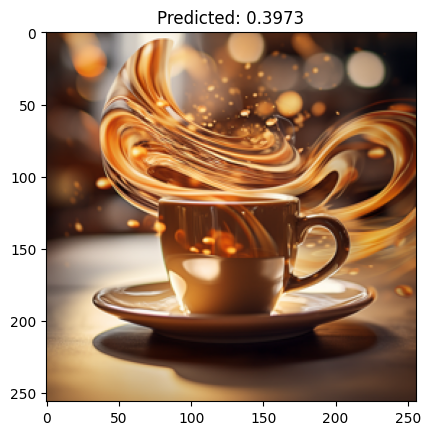

In [18]:
from google.colab import files

!mkdir /content/imgTest
%cd /content/imgTest
uploaded = files.upload()
uploadName = list(uploaded.keys())[0]

with pimg.open(uploadName) as img:
  res = img.resize(imgDim).convert('RGB')
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()